# Data exploration

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle, Polygon, Patch
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import sys
sys.path.append("../common/")

In [6]:
from data_utils import GRID_SIZE, TRAIN_WKT, LABELS, get_resized_polygons, TRAIN_IMAGE_IDS, ALL_IMAGE_IDS, generate_label_image
from image_utils import get_image_data, generate_pansharpened, DATA_3_BANDS, DATA_16_BANDS
from visu_utils import display_img_1b, display_img_3b, display_img_8b, display_polygons, display_labels

In [7]:
#!ls {DATA_16_BANDS} | head

## Visualize a training image

In [7]:
TRAIN_IMAGE_IDS

array(['6040_2_2', '6120_2_2', '6120_2_0', '6090_2_0', '6040_1_3',
       '6040_1_0', '6100_1_3', '6010_4_2', '6110_4_0', '6140_3_1',
       '6110_1_2', '6100_2_3', '6150_2_3', '6160_2_1', '6140_1_2',
       '6110_3_1', '6010_4_4', '6170_2_4', '6170_4_1', '6170_0_4',
       '6060_2_3', '6070_2_3', '6010_1_2', '6040_4_4', '6100_2_2'], dtype=object)

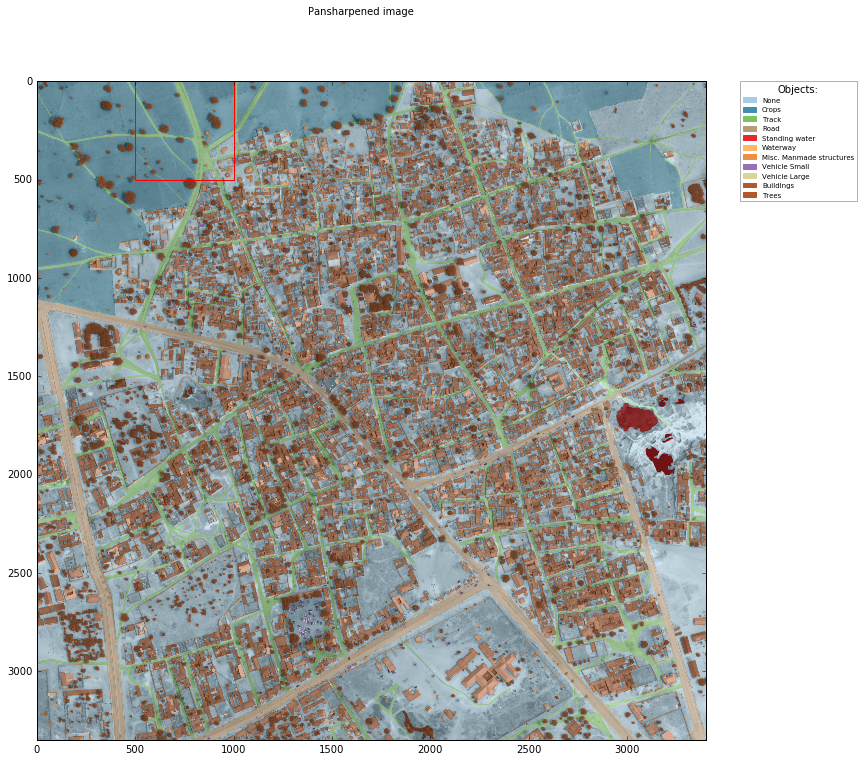

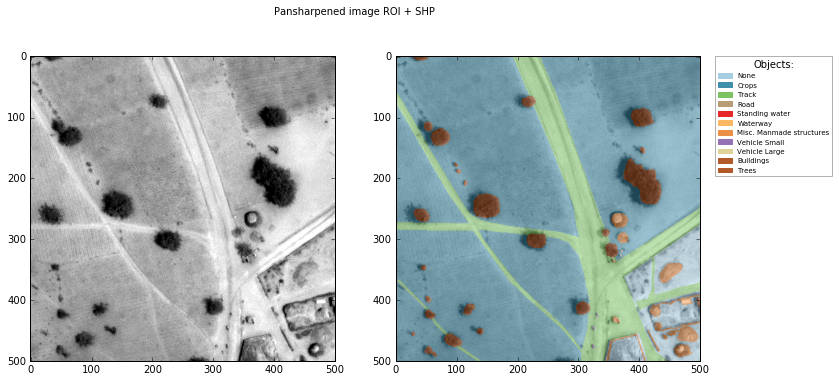

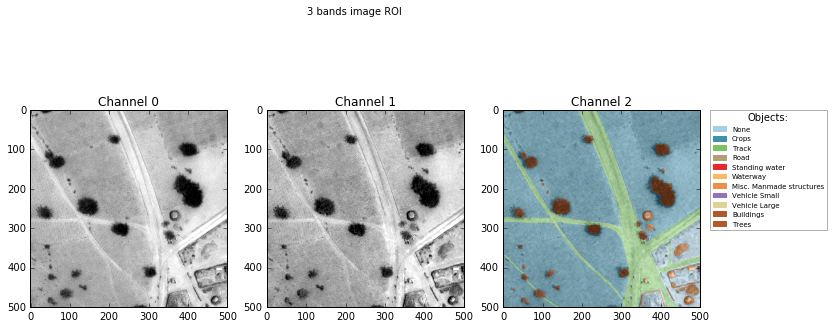

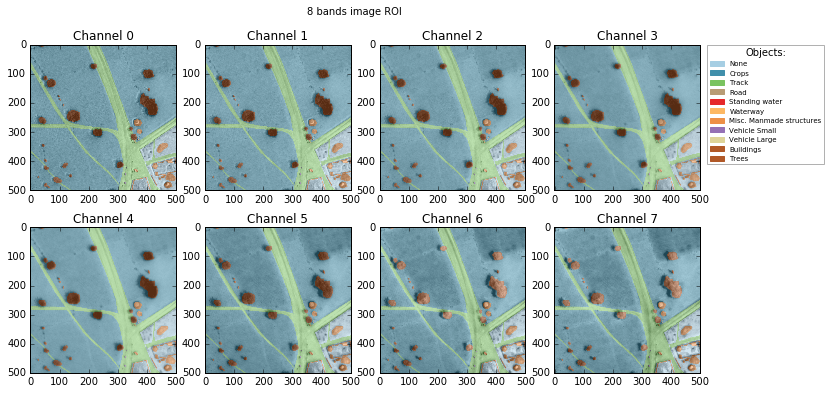

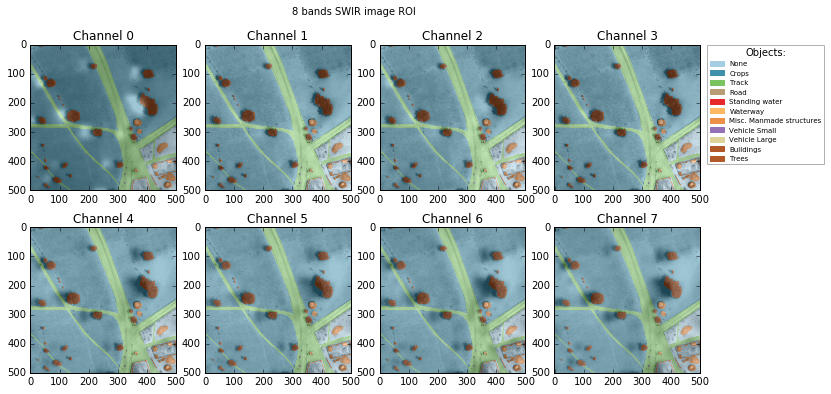

In [15]:
from ipywidgets import interact, IntSlider, FloatSlider   

image_id = "6120_2_2"

generate_pansharpened(image_id, 'ms')
generate_pansharpened(image_id, 'swir')

label_img = generate_label_image(image_id)
img_pan = get_image_data(image_id, 'pan')
#rpolygons_pan = get_resized_polygons(image_id, 'pan')   

try:
    img_3b = get_image_data(image_id, '3b')
    #rpolygons_3b = get_resized_polygons(image_id, '3b')   
except:
    img_3b = None
    
img_ms = get_image_data(image_id, 'ms_pan')
#rpolygons_ms = get_resized_polygons(image_id, 'ms_pan')   
img_swir = get_image_data(image_id, 'swir_pan')
#rpolygons_swir = get_resized_polygons(image_id, 'swir_pan')  


fig_size = (12, 6)
plus_shapes = True
def interactive_visu(roi_x, roi_w, roi_y, roi_h, alpha):
    
    roi = [roi_x, roi_y, roi_x+roi_w, roi_y+roi_h]
    
    plt.figure(figsize=(12, 12))
    ax = plt.gca()
    display_img_1b(img_pan)
    #display_polygons(rpolygons_pan)
    display_labels(label_img, alpha=alpha)
    ax.add_patch(Rectangle((roi_x, roi_y), roi_w, roi_h, alpha=1, facecolor='none', edgecolor='red'))
    plt.suptitle("Pansharpened image")
    
    plt.figure(figsize=fig_size)
    plt.subplot(121)
    display_img_1b(img_pan, roi)
    plt.suptitle("Pansharpened image ROI")
    plt.subplot(122)
    display_img_1b(img_pan, roi)
    #display_polygons(rpolygons_pan, roi, show_legend=False)
    display_labels(label_img, alpha, roi)
    plt.suptitle("Pansharpened image ROI + SHP")


    
    if img_3b is not None:
        plt.figure(figsize=fig_size)
        ax_array = display_img_3b(img_3b, roi)
        plt.suptitle("3 bands image ROI")
        if plus_shapes:
            display_labels(label_img, alpha, roi, ax_array)
            #display_polygons(rpolygons_3b, roi, ax_array)
        
    
    plt.figure(figsize=fig_size)
    ax_array = display_img_8b(img_ms, roi)
    plt.suptitle("8 bands image ROI")
    if plus_shapes:
        display_labels(label_img, alpha, roi, ax_array)
        #display_polygons(rpolygons_ms, roi, ax_array)
        

    plt.figure(figsize=fig_size)
    ax_array = display_img_8b(img_swir, roi)
    #ax_array = display_img_8b(img_swir, [r/4/6 for r in roi])
    plt.suptitle("8 bands SWIR image ROI")
    if plus_shapes:
        display_labels(label_img, alpha, roi, ax_array)
        #display_polygons(rpolygons_swir, roi, ax_array)

    
_ = interact(interactive_visu,           
         roi_x=IntSlider(value=500, min=0, max=3500, continuous_update=False), 
         roi_w=IntSlider(value=500, min=150, max=750, continuous_update=False), 
         roi_y=IntSlider(value=1, min=0, max=3500, continuous_update=False), 
         roi_h=IntSlider(value=500, min=150, max=750, continuous_update=False),
         alpha=FloatSlider(value=0.5, min=0, max=1.0, step=0.1, continuous_update=False))